# Salted

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
from torch.utils.data import Dataset, DataLoader, random_split

import os 
import glob
import cv2
import itertools

In [2]:
class Gait_Dataset_Salted(Dataset):
    def __init__(self, file_path):
        self.file_path = file_path
        self.inputs_acc, self.inputs_gyr, self.stride_length = get_sensor_salted(file_path)
#         self.inputs_spd = get_speed_salted(file_path)
        self.inputs_pst = get_position_salted(file_path, distance=True)
        
    def __len__(self) :
        return len(self.stride_length)
    
    def __getitem__(self, idx):
        if self.axis:
            return self.inputs_x[idx], self.inputs_y[idx], self.inputs_z[idx], self.stride_length[idx]
        
        return self.inputs_acc[idx], self.inputs_gyr[idx], self.stride_length[idx], self.inputs_pst[idx]
    
    
class Gait_Dataset_Axis_Salted(Dataset):
    def __init__(self, file_path, axis=None):
        self.file_path = file_path
        self.inputs_x, self.inputs_y, self.inputs_z, self.stride_length = get_axis_sensor_salted(file_path)
        self.inputs_pst = get_position_salted(file_path, distance=True)
        
    def __len__(self) :
        return len(self.stride_length)
    
    def __getitem__(self, idx):
        return self.inputs_x[idx], self.inputs_y[idx], self.inputs_z[idx], self.stride_length[idx], self.inputs_pst[idx]

In [3]:
def get_event_salted(file_path):
    
    df = pd.read_csv(file_path, skiprows=2)
    
    # 압력값 불러오기
    prs = df.filter(regex="R_value")
    prs_mean = np.mean(prs.iloc[:, 0:4], axis=1) 
    
    # Gaussian Filter : Smoothing pressure data
    prs_mean_gf = pd.Series(scipy.ndimage.gaussian_filter1d(prs_mean, 2))
    
    # Level Shift 
    lev_idx = prs_mean_gf > 2 # 가우시안 필터로 인해 0이 아닌 값으로 threshold 설정
    prs_lev = lev_idx.map(lambda x : 1 if x else 0)
    
    # HS, TO Index 추출
    event_idx = []
    for i in range(len(prs_lev)-1):
        if (prs_lev[i] - prs_lev[i+1]) != 0:
            event_idx.append(i)
            
    # HS 이벤트가 먼저 시작하도록 : 나중에 lev shift를 통해 구하는 방법으로 변경하는 것도 괜찮을 듯
    if np.diff(event_idx)[0] < np.diff(event_idx)[1]: # Swing Phase가 Stand Phase보다 길다는 것을 가정 : 장애 데이터에서도 확인 필요
        del event_idx[0]
    
    
    return event_idx

def get_sensor_salted(file_path, normalization=True):
    inputs_acc = []
    inputs_gyr = []
    stride_length = []
    for file_name in glob.glob(file_path):
        df = pd.read_csv(file_name, skiprows=2)
        acc = df.filter(regex="R_ACC")
        gyr = df.filter(regex="R_GYRO")
        event_idx = get_event_salted(file_name)

        # HS 이벤트 추출
        event_hs = event_idx[0::2]

        # m/s^2 단위 변환
        acc = (acc / 1000) * 9.8066
    #     acc_z = acc_z - np.mean(acc_z) # z축(상하)에 적용되는 중력가속도 제거 : 추가확인 필요

        # Normalization
        if normalization == True:
            scaler = MinMaxScaler()
            acc_norm = scaler.fit_transform(acc)
            gyr_norm = scaler.fit_transform(gyr)

        # 가속도와 자이로 센서 값
        for i in range(1, len(event_hs)):
            if normalization == True:
                inputs_acc.append(np.transpose(cv2.resize(acc_norm[event_hs[i-1]:event_hs[i]], dsize=(3, 300))))
                inputs_gyr.append(np.transpose(cv2.resize(gyr_norm[event_hs[i-1]:event_hs[i]], dsize=(3, 300))))
            else:
                inputs_acc.append(np.transpose(acc[event_hs[i-1]:event_hs[i]]))
                inputs_gyr.append(np.transpose(gyr[event_hs[i-1]:event_hs[i]]))

    
        if '3km' in file_name:
            stride_length.append(np.diff(event_hs) * (3000/3600))
        elif '4km' in file_name:
            stride_length.append(np.diff(event_hs) * (4000/3600))
        else:
            stride_length.append(np.diff(event_hs) * (5000/3600))
            
    stride_length = np.round(np.array(list(itertools.chain.from_iterable(stride_length))), 3)
    
    return inputs_acc, inputs_gyr, stride_length



def get_axis_sensor_salted(file_path, normalization=True):
    inputs_x = []
    inputs_y = []
    inputs_z = []
    stride_length = []
    for file_name in glob.glob(file_path):
        df = pd.read_csv(file_name, skiprows=2)
        acc = df.filter(regex="R_ACC")
        gyr = df.filter(regex="R_GYRO")
        event_idx = get_event_salted(file_name)

        # HS 이벤트 추출
        event_hs = event_idx[0::2]

        # m/s^2 단위 변환
        acc = (acc / 1000) * 9.8066
    #     acc_z = acc_z - np.mean(acc_z) # z축(상하)에 적용되는 중력가속도 제거 : 추가확인 필요

        # Normalization
        if normalization == True:
            scaler = MinMaxScaler()
            acc_norm = scaler.fit_transform(acc)
            gyr_norm = scaler.fit_transform(gyr)

            
        # 가속도와 자이로 센서 값
        for i in range(1, len(event_hs)):
            if normalization == True:
                inputs_x.append(np.vstack([np.transpose(cv2.resize(acc_norm[:, 0][event_hs[i-1]:event_hs[i]], dsize=(1, 300))), 
                                           np.transpose(cv2.resize(gyr_norm[:, 0][event_hs[i-1]:event_hs[i]], dsize=(1, 300)))]))
                inputs_y.append(np.vstack([np.transpose(cv2.resize(acc_norm[:, 1][event_hs[i-1]:event_hs[i]], dsize=(1, 300))), 
                                           np.transpose(cv2.resize(gyr_norm[:, 1][event_hs[i-1]:event_hs[i]], dsize=(1, 300)))]))
                inputs_z.append(np.vstack([np.transpose(cv2.resize(acc_norm[:, 2][event_hs[i-1]:event_hs[i]], dsize=(1, 300))), 
                                           np.transpose(cv2.resize(gyr_norm[:, 2][event_hs[i-1]:event_hs[i]], dsize=(1, 300)))]))
            else:
                inputs_acc.append(np.transpose(acc[event_hs[i-1]:event_hs[i]]))
                inputs_gyr.append(np.transpose(gyr[event_hs[i-1]:event_hs[i]]))

    
        if '3km' in file_name:
            stride_length.append(np.diff(event_hs) * (3000/3600))
        elif '4km' in file_name:
            stride_length.append(np.diff(event_hs) * (4000/3600))
        else:
            stride_length.append(np.diff(event_hs) * (5000/3600))
            
    stride_length = np.round(np.array(list(itertools.chain.from_iterable(stride_length))), 3)
    
    return inputs_x, inputs_y, inputs_z, stride_length


def get_speed_salted(file_path):
    inputs_acc, _, _ = get_sensor_salted(file_path, normalization=False)
    inputs_spd = []
    for i in range(len(inputs_acc)):
        spd = pd.DataFrame(scipy.integrate.cumulative_trapezoid(inputs_acc[i], dx=(1/100)))
        inputs_spd.append(spd) #m/s
    return inputs_spd

def get_position_salted(file_path, distance=False):
    inputs_spd = get_speed_salted(file_path)
    inputs_pst = []
    for i in range(len(inputs_spd)):
        pst = pd.DataFrame(scipy.integrate.cumulative_trapezoid(inputs_spd[i], dx=(1/100)))
        if distance==True:
            pst = np.sum(pst, axis=1)
        inputs_pst.append(pst)
    return inputs_pst


In [18]:
file_path = "D:\gait_dataset/salted/3km/train/*"
inputs_x, inputs_y, inputs_z, stride_length = get_axis_sensor_salted(file_path)

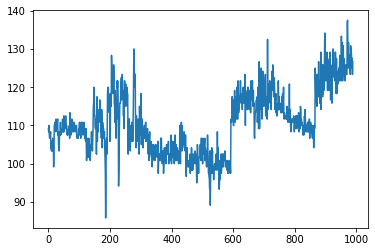

In [19]:
plt.plot(stride_length)

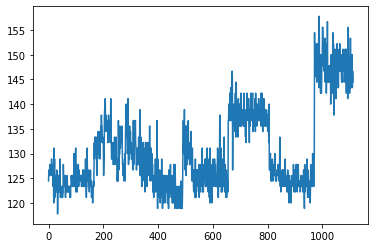

In [17]:
plt.plot(stride_length)

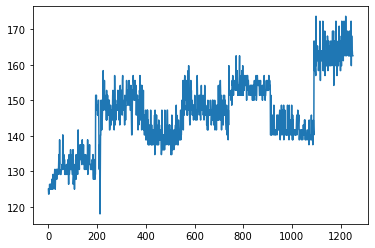

In [15]:
plt.plot(stride_length)

In [368]:
pd.DataFrame(inputs_x[0])

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.511261,0.516556,0.531472,0.546154,0.557464,0.568774,0.546937,0.515465,0.495277,0.487081,...,0.626147,0.626639,0.622232,0.613216,0.607781,0.614666,0.621550,0.644836,0.669259,0.677928
1,0.543176,0.533124,0.504806,0.474798,0.420421,0.366045,0.350999,0.347384,0.343842,0.340378,...,0.780154,0.759167,0.736110,0.711106,0.683943,0.649348,0.614755,0.577672,0.540417,0.527193


In [351]:
pd.DataFrame(np.vstack([inputs_acc[0], inputs_gyr[0]]))

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.511261,0.516556,0.531472,0.546154,0.557464,0.568774,0.546937,0.515465,0.495277,0.487081,...,0.626147,0.626639,0.622232,0.613216,0.607782,0.614666,0.621550,0.644835,0.669259,0.677928
1,0.688371,0.689167,0.691410,0.684911,0.552438,0.419964,0.332047,0.257080,0.212628,0.200614,...,0.652609,0.665824,0.677018,0.686308,0.696267,0.708521,0.720775,0.721870,0.722190,0.722304
2,0.635383,0.632139,0.623000,0.614093,0.608524,0.602955,0.638322,0.685587,0.691322,0.652910,...,0.611681,0.639097,0.656655,0.664937,0.666884,0.647036,0.627187,0.652872,0.681717,0.691956
3,0.543176,0.533124,0.504806,0.474798,0.420421,0.366045,0.350999,0.347384,0.343842,0.340378,...,0.780154,0.759167,0.736110,0.711106,0.683943,0.649349,0.614755,0.577672,0.540417,0.527193
4,0.558357,0.557129,0.553668,0.551684,0.570980,0.590275,0.591208,0.586804,0.584127,0.583289,...,0.472070,0.506571,0.537452,0.564927,0.591316,0.613967,0.636619,0.655740,0.674616,0.681316
5,0.428571,0.433266,0.446490,0.459297,0.466083,0.472869,0.474397,0.474397,0.471656,0.466001,...,0.384936,0.397551,0.411242,0.425946,0.440806,0.456205,0.471605,0.479682,0.487251,0.489938


In [352]:
inputs_gyr[0]

array([[0.54317581, 0.53312407, 0.50480626, 0.47479763, 0.42042141,
        0.36604519, 0.3509992 , 0.34738416, 0.34384213, 0.34037772,
        0.33572094, 0.32613104, 0.31654114, 0.3101305 , 0.30405523,
        0.30739029, 0.31662872, 0.32684451, 0.33909547, 0.35100322,
        0.35326262, 0.35552202, 0.35774405, 0.35995324, 0.36622169,
        0.37736806, 0.39026139, 0.41205205, 0.4338427 , 0.45888084,
        0.48438695, 0.50182994, 0.51352861, 0.52206949, 0.52302346,
        0.52398164, 0.52604021, 0.52809877, 0.53004983, 0.53195776,
        0.53388697, 0.53584512, 0.53772949, 0.53913533, 0.54054118,
        0.54186233, 0.54316776, 0.54377851, 0.54382871, 0.54389215,
        0.54399256, 0.54409298, 0.54409567, 0.54409567, 0.54419857,
        0.5443492 , 0.544638  , 0.54514009, 0.54554387, 0.54509199,
        0.54464011, 0.54475969, 0.54501073, 0.54481545, 0.54421295,
        0.54386762, 0.54436971, 0.54487179, 0.5444272 , 0.54392511,
        0.54371795, 0.54366774, 0.54365394, 0.54

In [334]:
file_path = "D:\gait_dataset/salted/*"
inputs_acc, inputs_gyr, stride_length = get_sensor_salted(file_path)

(19000,)
(18775,)
(18421,)
(18837,)
(18217,)
(18451,)
(18547,)
(19315,)
(19981,)
(19936,)
(18946,)
(19276,)
(18532,)
(18733,)
(19051,)
(19333,)
(18655,)
(18400,)
(18499,)
(18835,)
(18997,)
(18934,)
(18700,)
(18739,)


In [335]:
inputs_acc[0].shape

(300, 3)

In [315]:
inputs_acc[0].shape

(3, 300)

In [ ]:
np.transpose(cv2.resize(acc_norm[event_hs[i-1]:event_hs[i]], dsize=(3, 300)))